# Milestone Project 1 : Food vision big 

This notebook, we'll train a feature extraction using base model EfficientNetB4

In [1]:
# check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f93faba9-5be9-b630-5541-7d8728dc4131)


In [2]:
# downgrade the tensorflow version because the EfficientNetB0 is running error when using mixed precision
!pip install tensorflow==2.4.1  

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 3.8 MB 48.0 MB/s 
     |████████████████████████████████| 2.9 MB 67.4 MB/s 
     |████████████████████████████████| 462 kB 66.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

## Get helper functions

In [3]:
!wget https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py

--2021-08-13 02:10:25--  https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.98K  --.-KB/s    in 0s      

2021-08-13 02:10:25 (57.3 MB/s) - ‘helper_functions.py’ saved [11240/11240]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix

## Use TensorFlow Dataset to download data

In [5]:
import tensorflow_datasets as tfds

In [7]:
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [8]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteLIQRYZ/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteLIQRYZ/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [13]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
# Take one sample of the train_data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

# output info about our training sample
for image, label in train_one_sample:
  print(f"""
    Image shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
  """)


    Image shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
  


In [15]:
# What are the min and the max value in the image tensor
import tensorflow as tf

tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

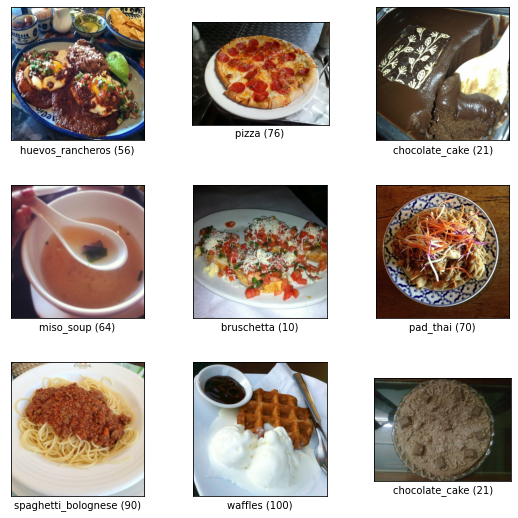

In [16]:
import matplotlib.pyplot as plt

fig = tfds.show_examples(train_data, ds_info)

## Create preprocessing functions for our data

Neural network perform best when data in a certain way (e.g batched, normalized, etc).

However, not all data, including data come tfds comes like this.

So in order to get it ready for ANN, you'll often have to write preprocessing functions and map it to your data.

What we know about data:
* In `uint8` datatype.
* Comprised of all different size tensors (different size images).
* Not scaled (value still in between 0 to 255).

What we know model likes:
* Data in `float32` dtype (or mixed precision `float16` and `float32`).
* For batches, tensorflow likes all of the tensor within a batch to be of the same size.
* Scaled (value between 0 and 1) also called normalized tensor generally perform better.

With these points in mind, we got a few thing we can tackle with a preprocessing function.

Since we're going to be using EfficientNetBx pretrained model from `tf.keras.applications` we don't need to rescale our data (these architecture have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size.
2. Convert the dtype of our images from `unint8` to `float32`.

In [17]:
import tensorflow as tf

def preprocess_image(img, label, rescale=False, img_size=224):
  """
  Reshape img to (img_size, img_size, 3) and Rescaling if true
  """
  img = tf.image.resize(img, size=[img_size, img_size])
  if rescale:
    img = img/255.
  return tf.cast(img, dtype=tf.float32), label

In [18]:
preprocessed_img = preprocess_image(image, label)[0]
print(f"Image before processing:\n {image[:2]}..., \n shape: {image.shape}, dtype {image.dtype}")
print(f"Image after  processing:\n {preprocessed_img[:2]}..., \n shape: {preprocessed_img.shape}, dtype {preprocessed_img.dtype}")

Image before processing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
 shape: (512, 512, 3), dtype <dtype: 'uint8'>
Image after  processing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]..., 
 shape: (224, 224, 3), dtype <dtype: 'float32'>


## Batch and prepare dataset

We're now going to make our data input pipeline run really fast.

Read the document here: https://www.tensorflow.org/guide/data_performance

In [20]:
# Map preprocess function to train_data and run parallel
train_data_optimized = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle the train data and turn into batches and prefetch it
train_data_optimized = train_data_optimized.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocess function to test data and run parallel
test_data_optimized = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# turn test data into batches and prefetch it -> not shuffle for validation
test_data_optimized = test_data_optimized.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
train_data_optimized, test_data_optimized

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Set the mixed precision 

In [23]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

tf.keras.mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

## Build a feature extraction model

this time we'll using EfficientNetB4

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [25]:
input_shape = (224,224,3)

In [28]:
# Create the inputs layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Create preprocess layers
# x = preprocessing.Rescaling(1./255)(inputs)

# Create base model
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False # Freeze all layers

# Stack the base model
x = base_model(inputs, training=False)

# Create GlobalAveragePool2D layer
x = layers.GlobalAveragePooling2D(name="global_average_pool_2D_layer")(x)

# Create Fully Connectected layer
x = layers.Dense(len(class_names))(x)
# Create output layer
outputs = layers.Activation(activation="softmax",
                            dtype=tf.float32, # we should store number in float32 for stable
                            name="output_layer")(x)

# Create the model
model = Model(inputs, outputs)

In [29]:
# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [31]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb4 False <Policy "mixed_float16">
global_average_pool_2D_layer True <Policy "mixed_float16">
dense_1 True <Policy "mixed_float16">
output_layer True <Policy "float32">


In [32]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_3 False <Policy "float32">
rescaling_2 False <Policy "mixed_float16">
normalization_2 False <Policy "float32">
stem_conv_pad False <Policy "mixed_float16">
stem_conv False <Policy "mixed_float16">
stem_bn False <Policy "mixed_float16">
stem_activation False <Policy "mixed_float16">
block1a_dwconv False <Policy "mixed_float16">
block1a_bn False <Policy "mixed_float16">
block1a_activation False <Policy "mixed_float16">
block1a_se_squeeze False <Policy "mixed_float16">
block1a_se_reshape False <Policy "mixed_float16">
block1a_se_reduce False <Policy "mixed_float16">
block1a_se_expand False <Policy "mixed_float16">
block1a_se_excite False <Policy "mixed_float16">
block1a_project_conv False <Policy "mixed_float16">
block1a_project_bn False <Policy "mixed_float16">
block1b_dwconv False <Policy "mixed_float16">
block1b_bn False <Policy "mixed_float16">
block1b_activation False <Policy "mixed_float16">
block1b_se_squeeze False <Policy "mixed_float16">
block1b_se_reshape False <Policy "mi

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pool_2D_layer (None, 1792)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               181093    
_________________________________________________________________
output_layer (Activation)    (None, 101)               0         
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


## Fit the feature extraction model

In [34]:
# create callback 
checkpoint_path = "Food101_feature_extract_efficientnetb4/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
                                                   experiment_name="efficientnetb4_101_classes_all_data_feature_extract")

Saving TensorBoard log files to: training_logs/efficientnetb4_101_classes_all_data_feature_extract/20210813-025131


In [35]:
# Fit the feature extraction model with mixed precision 
history_efficientnetb4_feature_extraction = model.fit(train_data_optimized,
                                                        epochs=3,
                                                        steps_per_epoch=len(train_data_optimized),
                                                        validation_data=test_data_optimized,
                                                        validation_steps=int(0.15 * len(test_data_optimized)),
                                                        callbacks=[tensorboard_callback,
                                                                   checkpoint_callback])

Epoch 1/3
2368/2368 [==============================] - 270s 96ms/step - loss: 2.3273 - accuracy: 0.4542 - val_loss: 1.3319 - val_accuracy: 0.6552
Epoch 2/3
2368/2368 [==============================] - 224s 94ms/step - loss: 1.4277 - accuracy: 0.6306 - val_loss: 1.2413 - val_accuracy: 0.6727
Epoch 3/3
2368/2368 [==============================] - 211s 88ms/step - loss: 1.2679 - accuracy: 0.6667 - val_loss: 1.2092 - val_accuracy: 0.6772


In [37]:
results_feature_extract = model.evaluate(test_data_optimized)
results_feature_extract

790/790 [==============================] - 68s 86ms/step - loss: 1.2015 - accuracy: 0.6779


[1.2014997005462646, 0.6779009699821472]

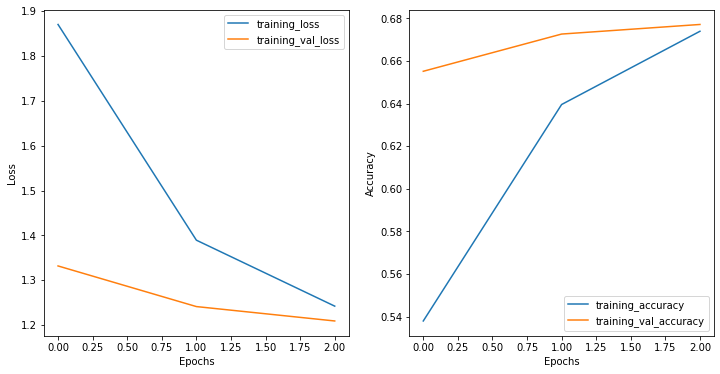

In [62]:
plot_loss_curves(history_efficientnetb4_feature_extraction)

## Fine tuning last 10 layers

In [38]:
# unfreeze all layers in the base_model
base_model.trainable = True

# Freeze all layers except last 10 layers 
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [40]:
# Compile the model again
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [41]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb4 True <Policy "mixed_float16">
global_average_pool_2D_layer True <Policy "mixed_float16">
dense_1 True <Policy "mixed_float16">
output_layer True <Policy "float32">


In [43]:
for i, layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable, layer.dtype_policy)

0 input_3 False <Policy "float32">
1 rescaling_2 False <Policy "mixed_float16">
2 normalization_2 False <Policy "float32">
3 stem_conv_pad False <Policy "mixed_float16">
4 stem_conv False <Policy "mixed_float16">
5 stem_bn False <Policy "mixed_float16">
6 stem_activation False <Policy "mixed_float16">
7 block1a_dwconv False <Policy "mixed_float16">
8 block1a_bn False <Policy "mixed_float16">
9 block1a_activation False <Policy "mixed_float16">
10 block1a_se_squeeze False <Policy "mixed_float16">
11 block1a_se_reshape False <Policy "mixed_float16">
12 block1a_se_reduce False <Policy "mixed_float16">
13 block1a_se_expand False <Policy "mixed_float16">
14 block1a_se_excite False <Policy "mixed_float16">
15 block1a_project_conv False <Policy "mixed_float16">
16 block1a_project_bn False <Policy "mixed_float16">
17 block1b_dwconv False <Policy "mixed_float16">
18 block1b_bn False <Policy "mixed_float16">
19 block1b_activation False <Policy "mixed_float16">
20 block1b_se_squeeze False <Policy 

In [45]:
# create callback 
checkpoint_path = "Food101_fine_tune_10_layers_efficientnetb4/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
                                                   experiment_name="efficientnetb4_101_classes_all_data_fine_tune_10_layers")

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3)

Saving TensorBoard log files to: training_logs/efficientnetb4_101_classes_all_data_fine_tune_10_layers/20210813-031004


In [47]:
initial_epochs = 3

fine_tune_epochs = initial_epochs + 10

In [48]:
# Fit the feature extraction model with mixed precision 
history_efficientnetb4_fine_tune_10_layer = model.fit(train_data_optimized,
                                                        epochs=fine_tune_epochs,
                                                        initial_epoch=inital_epochs,
                                                        steps_per_epoch=len(train_data_optimized),
                                                        validation_data=test_data_optimized,
                                                        validation_steps=int(0.15 * len(test_data_optimized)),
                                                        callbacks=[tensorboard_callback,
                                                                   earlystopping_callback,
                                                                   checkpoint_callback])

Epoch 4/13
2368/2368 [==============================] - 236s 92ms/step - loss: 1.1104 - accuracy: 0.7091 - val_loss: 1.0808 - val_accuracy: 0.7100
Epoch 5/13
2368/2368 [==============================] - 216s 91ms/step - loss: 0.8999 - accuracy: 0.7594 - val_loss: 1.0660 - val_accuracy: 0.7150
Epoch 6/13
2368/2368 [==============================] - 216s 90ms/step - loss: 0.7184 - accuracy: 0.8084 - val_loss: 1.0840 - val_accuracy: 0.7142
Epoch 7/13
2368/2368 [==============================] - 216s 90ms/step - loss: 0.5610 - accuracy: 0.8537 - val_loss: 1.1203 - val_accuracy: 0.7082
Epoch 8/13
2368/2368 [==============================] - 216s 91ms/step - loss: 0.4270 - accuracy: 0.8956 - val_loss: 1.1892 - val_accuracy: 0.6999


In [49]:
results_fine_tune_10_layers = model.evaluate(test_data_optimized)
results_fine_tune_10_layers

790/790 [==============================] - 67s 84ms/step - loss: 1.1633 - accuracy: 0.7027


[1.1632651090621948, 0.7026534676551819]

In [50]:
checkpoint_path

'Food101_fine_tune_10_layers_efficientnetb4/checkpoint.ckpt'

In [51]:
model.load_weights(checkpoint_path)
results_fine_tune_10_layers = model.evaluate(test_data_optimized)
results_fine_tune_10_layers

790/790 [==============================] - 63s 79ms/step - loss: 1.0524 - accuracy: 0.7114


[1.0524293184280396, 0.7113663554191589]

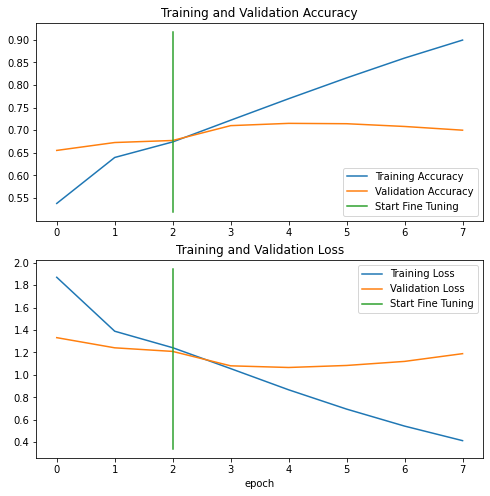

In [55]:
compare_historys(history_efficientnetb4_feature_extraction, history_efficientnetb4_fine_tune_10_layer, 3)

## Fine tune more 20 layers (last 30 layers)

In [52]:
# unfreeze all layers in the base_model
base_model.trainable = True

# Freeze all layers except last 10 layers 
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [53]:
for i, layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable, layer.dtype_policy)

0 input_3 False <Policy "float32">
1 rescaling_2 False <Policy "mixed_float16">
2 normalization_2 False <Policy "float32">
3 stem_conv_pad False <Policy "mixed_float16">
4 stem_conv False <Policy "mixed_float16">
5 stem_bn False <Policy "mixed_float16">
6 stem_activation False <Policy "mixed_float16">
7 block1a_dwconv False <Policy "mixed_float16">
8 block1a_bn False <Policy "mixed_float16">
9 block1a_activation False <Policy "mixed_float16">
10 block1a_se_squeeze False <Policy "mixed_float16">
11 block1a_se_reshape False <Policy "mixed_float16">
12 block1a_se_reduce False <Policy "mixed_float16">
13 block1a_se_expand False <Policy "mixed_float16">
14 block1a_se_excite False <Policy "mixed_float16">
15 block1a_project_conv False <Policy "mixed_float16">
16 block1a_project_bn False <Policy "mixed_float16">
17 block1b_dwconv False <Policy "mixed_float16">
18 block1b_bn False <Policy "mixed_float16">
19 block1b_activation False <Policy "mixed_float16">
20 block1b_se_squeeze False <Policy 

In [54]:
# create callback 
checkpoint_path = "Food101_fine_tune_30_layers_efficientnetb4/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
                                                   experiment_name="efficientnetb4_101_classes_all_data_fine_tune_30_layers")

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3)

Saving TensorBoard log files to: training_logs/efficientnetb4_101_classes_all_data_fine_tune_30_layers/20210813-033436


In [56]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # 100x the default
    metrics=["accuracy"]
)

In [57]:
initial_epochs = 5

fine_tune_epochs = initial_epochs + 10

In [58]:
# Fit the feature extraction model with mixed precision 
history_efficientnetb4_fine_tune_30_layer = model.fit(train_data_optimized,
                                                        epochs=fine_tune_epochs,
                                                        initial_epoch=inital_epochs,
                                                        steps_per_epoch=len(train_data_optimized),
                                                        validation_data=test_data_optimized,
                                                        validation_steps=int(0.15 * len(test_data_optimized)),
                                                        callbacks=[tensorboard_callback,
                                                                   earlystopping_callback,
                                                                   checkpoint_callback])

Epoch 4/15
2368/2368 [==============================] - 245s 98ms/step - loss: 0.6636 - accuracy: 0.8239 - val_loss: 1.0996 - val_accuracy: 0.7142
Epoch 5/15
2368/2368 [==============================] - 231s 97ms/step - loss: 0.5672 - accuracy: 0.8517 - val_loss: 1.1181 - val_accuracy: 0.7164
Epoch 6/15
2368/2368 [==============================] - 230s 96ms/step - loss: 0.4998 - accuracy: 0.8711 - val_loss: 1.1477 - val_accuracy: 0.7140
Epoch 7/15
2368/2368 [==============================] - 230s 96ms/step - loss: 0.4393 - accuracy: 0.8894 - val_loss: 1.1797 - val_accuracy: 0.7076
Epoch 8/15
2368/2368 [==============================] - 229s 96ms/step - loss: 0.3833 - accuracy: 0.9066 - val_loss: 1.2196 - val_accuracy: 0.7071


In [59]:
results_fine_tune_30_layers = model.evaluate(test_data_optimized)
results_fine_tune_30_layers

790/790 [==============================] - 66s 84ms/step - loss: 1.1955 - accuracy: 0.7093


[1.1954814195632935, 0.7092673182487488]

## Fine tune the whole base model layers

this time we load the feature extract checkpoint and then fine tune the whole model

In [60]:
# create callback 
checkpoint_path = "Food101_feature_extract_efficientnetb4/checkpoint.ckpt"

In [61]:
model.load_weights(checkpoint_path)
model.evaluate(test_data_optimized)

790/790 [==============================] - 63s 80ms/step - loss: 1.2015 - accuracy: 0.6779


[1.2014997005462646, 0.6779009699821472]

In [63]:
# Unfreeze all the layers in the base model
base_model.trainable = True

In [64]:
# Compile the model again
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x the default lr
    metrics=["accuracy"]
)

In [68]:
# create callback 
checkpoint_path = "Food101_fine_tune_all_layers_efficientnetb4/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
                                                   experiment_name="efficientnetb4_101_classes_all_data_fine_tune_all_layers")

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=5)

Saving TensorBoard log files to: training_logs/efficientnetb4_101_classes_all_data_fine_tune_all_layers/20210813-040042


In [69]:
initial_epochs = 3

fine_tune_epochs = initial_epochs + 20

In [70]:
# Fit the feature extraction model with mixed precision 
history_efficientnetb4_fine_tune_all_layer = model.fit(train_data_optimized,
                                                        epochs=fine_tune_epochs,
                                                        initial_epoch=inital_epochs,
                                                        steps_per_epoch=len(train_data_optimized),
                                                        validation_data=test_data_optimized,
                                                        validation_steps=int(0.15 * len(test_data_optimized)),
                                                        callbacks=[tensorboard_callback,
                                                                   earlystopping_callback,
                                                                   checkpoint_callback])

Epoch 4/23
2368/2368 [==============================] - 684s 279ms/step - loss: 1.0390 - accuracy: 0.7225 - val_loss: 0.6910 - val_accuracy: 0.8096
Epoch 5/23
2368/2368 [==============================] - 652s 275ms/step - loss: 0.4193 - accuracy: 0.8828 - val_loss: 0.8002 - val_accuracy: 0.7940
Epoch 6/23
2368/2368 [==============================] - 657s 274ms/step - loss: 0.1437 - accuracy: 0.9566 - val_loss: 0.9199 - val_accuracy: 0.7953
Epoch 7/23
2368/2368 [==============================] - 650s 274ms/step - loss: 0.0906 - accuracy: 0.9722 - val_loss: 0.9634 - val_accuracy: 0.8027
Epoch 8/23
  17/2368 [..............................] - ETA: 10:36 - loss: 0.0590 - accuracy: 0.9827

KeyboardInterrupt: ignored

In [71]:
results_fine_tune_all_layers = model.evaluate(test_data_optimized)

results_fine_tune_all_layers

790/790 [==============================] - 67s 85ms/step - loss: 1.0384 - accuracy: 0.7851


[1.0383784770965576, 0.7850692868232727]

In [72]:
checkpoint_path = "Food101_fine_tune_all_layers_efficientnetb4/checkpoint.ckpt"

model.load_weights(checkpoint_path)

model.evaluate(test_data_optimized)

790/790 [==============================] - 67s 85ms/step - loss: 0.7009 - accuracy: 0.8021


[0.7009186744689941, 0.80213862657547]

Wow, the valid accuracy is over 80%, beat [the paper](https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf)'s accuracy (77.4%) already 😎😎😎

In [73]:
# Save the model to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
model.save("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/101_classes_efficientnetb4_fine_tune_all_layers.h5")

In [75]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/101_classes_efficientnetb4_fine_tune_all_layers.h5")

In [76]:
loaded_model.evaluate(test_data_optimized)

790/790 [==============================] - 68s 81ms/step - loss: 0.7009 - accuracy: 0.8021


[0.7009186744689941, 0.80213862657547]

### summary

>🔑**Summary :** Compare to EfficientNetB0, the EfficientNetB4 is when performce fine tuning is results more accuracy, but train longer.

In [78]:
compare_historys(history_efficientnetb4_feature_extraction, history_efficientnetb4_fine_tune_all_layer, 3)

NameError: ignored